# Visualizing Layer Representations in Neural Networks

https://becominghuman.ai/visualizing-representations-bd9b62447e38 <br>
Visualizing intermediate (hidden) layer features using dimension reduction techniques.
* IMDB sentiment classification task (25000 training and 25000 test examples)
* Bidirectional LSTM model using a dropout

In [1]:
from __future__ import print_function
import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.datasets import imdb

Using Theano backend.


In [2]:
import keras # 해당 문서는 keras=1.2.2 버젼에 맞춘 것임
keras.__version__

'1.2.2'

## Build Model and Train Model

In [3]:
max_features = 10000 # 20000
# cut texts after this number of words
# (among top max_features most common words)
maxlen = 50 #100
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(nb_words=max_features) # num_words
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
y_train = np.array(y_train)
y_test = np.array(y_test)

model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen))
model.add(Bidirectional(LSTM(32))) # 64
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000L, 50L)
x_test shape: (25000L, 50L)


In [4]:
print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          nb_epoch=2,
          verbose=1,
          validation_split=0.2) # epochs

Train...
Train on 20000 samples, validate on 5000 samples
Epoch 1/2
20000/20000 [==============================] - 65s - loss: 0.4800 - acc: 0.7620 - val_loss: 0.4616 - val_acc: 0.7972
Epoch 2/2
20000/20000 [==============================] - 82s - loss: 0.3092 - acc: 0.8710 - val_loss: 0.4112 - val_acc: 0.8114ETA: 5s - loss: 0.3086 - acc:


## Extract hidden-layer representations

In [6]:
def create_truncated_model(trained_model):
    # 똑같은 모델을 다시 만들고, 이전에 학습된 weight들을 주입해준다
    model = Sequential()
    model.add(Embedding(max_features, 128, input_length=maxlen))
    model.add(Bidirectional(LSTM(32)))
    for i, layer in enumerate(model.layers):
        layer.set_weights(trained_model.layers[i].get_weights()) # 학습된 weight 주입하기
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

truncated_model = create_truncated_model(model)
hidden_features = truncated_model.predict(x_test) # 예측한 것 자체가 representation이 된다

In [8]:
print(x_test.shape)

(25000L, 50L)


In [7]:
print((hidden_features).shape) # 클래스가 2개 있으므로, 32 x 2 = 64

(25000L, 64L)


## Visualization using T-SNE

As the author experience, T-SNE does not scale very well with several features and more than a few thousand instances. <br>

Our PCA variance is ~0.99, which implies that the reduced dimensions do represent the hidden features well (scale is 0 to 1).

Dimension을 줄이는데 PCA와 T-SNE를 같이 사용하겠다 (위와 같은 T-SNE단점때문에) <br>
먼저 128->20으로 줄이는 데는 PCA를 사용하고 <br>
그리고 20-> 2로 줄이는 데는 T-SNE를 사용한다

In [9]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=20)
pca_result = pca.fit_transform(hidden_features)
print('Variance PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))
##Variance PCA: 0.993621154832802

#Run T-SNE on the PCA features.
tsne = TSNE(n_components=2, verbose = 1)
tsne_results = tsne.fit_transform(pca_result[:5000])

Variance PCA: 0.991728067398
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.008s...
[t-SNE] Computed neighbors for 5000 samples in 0.526s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.195209
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.136703
[t-SNE] Error after 1000 iterations: 1.478869


In [14]:
color_map

array([1, 1, 1, ..., 0, 0, 1], dtype=int64)

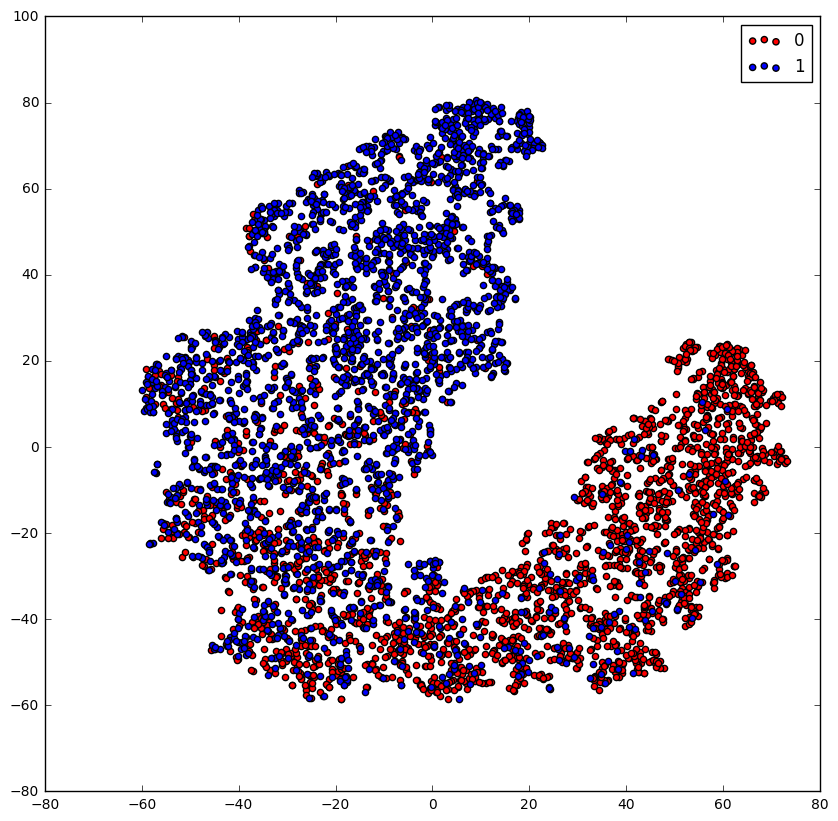

In [17]:
from keras.utils import np_utils
import matplotlib.pyplot as plt
%matplotlib inline

y_test_cat = np_utils.to_categorical(y_test[:5000], nb_classes = 2) # one-hot으로 바꿈

color_map = np.argmax(y_test_cat, axis=1)
plt.figure(figsize=(10,10))
for cl in range(2):
    indices = np.where(color_map==cl)
    indices = indices[0]
    if cl==0:
        color = 'red'
    else:
        color = 'blue'
    plt.scatter(tsne_results[indices,0], tsne_results[indices, 1], c=color, label=cl)
plt.legend()
plt.show()

In [12]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_preds))

NameError: name 'y_preds' is not defined

Understanding and visualizing the outputs at different layers can help understand which layer is causing major errors in learning representations.

모든 layer를 다 visualization 해보면 어디서 문제점이 발생하는지 볼 수 있기도 하겠다